In [1]:
import matplotlib.pyplot as plt
import mplcyberpunk

plt.style.use("cyberpunk")
import pandas as pd
import numpy as np

# AdaBoost

## From Scratch

In [2]:
from sklearn.datasets import make_moons

rnd = np.random.RandomState(0)
X, y = make_moons(n_samples=100, noise=0.07, random_state=rnd)

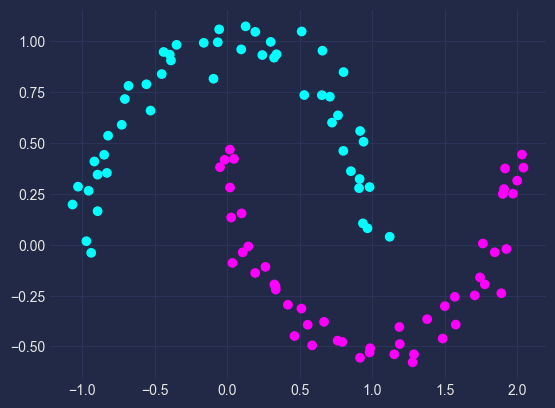

In [3]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [4]:
from sklearn.tree import DecisionTreeClassifier

weak_learner = DecisionTreeClassifier(max_depth=1)
weak_learner.fit(X, y)

DecisionTreeClassifier(max_depth=1)

In [5]:
error_rate = 1 - weak_learner.score(X, y)
error_rate

0.15000000000000002

In [6]:
mask = (y == weak_learner.predict(X))

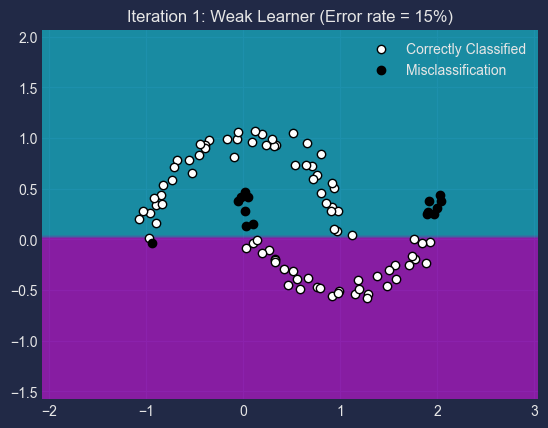

In [7]:
from sklearn.inspection import DecisionBoundaryDisplay

DecisionBoundaryDisplay.from_estimator(weak_learner, X=X, response_method="predict", alpha=0.5)
plt.title(f"Iteration 1: Weak Learner (Error rate = {error_rate:.0%})")
plt.scatter(X[mask, 0], X[mask, 1], c="white", edgecolors="k", label="Correctly Classified")
plt.scatter(X[~mask, 0], X[~mask, 1], c="black", edgecolors="k", label="Misclassification")
plt.legend()
plt.show()

In [8]:
from sklearn.metrics import accuracy_score


def fit_boosting(X, y, n_estimators=10, visualize=False):
    n_samples, n_features = X.shape
    weights = np.ones((n_samples,))
    estimators = []

    for t in range(n_estimators):
        # initialise the weights
        weights = np.divide(weights, np.sum(weights))

        # create the weak learner
        stumps = DecisionTreeClassifier(max_depth=1)

        # fit the data to weak learner with corresponding weights
        stumps.fit(X, y, sample_weight=weights)

        y_pred = stumps.predict(X)

        # use the exponential function to the find the alpha of each weak learner
        error_rate_ = 1 - accuracy_score(y, y_pred, sample_weight=weights)
        alpha_ = 0.5 * np.log((1 - error_rate_) / error_rate_)

        if visualize and t % 4 == 0:
            # Visualization the sample weight and Decision stumps
            ax = plt.subplot(n_estimators // 4, 2, (t // 4 + 1) * 2 - 1)
            plt.setp(ax, xticks=(), yticks=(), title=f"Iteration {t + 1} :Sample Weights")
            plt.scatter(X[:, 0], X[:, 1], s=weights * 500, c=y)

            ax = plt.subplot(n_estimators // 4, 2, (t // 4 + 1) * 2)
            plt.setp(ax, xticks=(), yticks=(), title=f"Iteration {t + 1} :Weak Learner (err={error_rate_:.0%})")
            DecisionBoundaryDisplay.from_estimator(estimator=stumps, X=X,
                                                   response_method="predict", alpha=0.5, ax=ax)
            mask_ = (y == y_pred)
            plt.scatter(X[mask_, 0], X[mask_, 1], c="white", edgecolors="k", label="Correctly Classified")
            plt.scatter(X[~mask_, 0], X[~mask_, 1], c="black", edgecolors="k", label="Misclassification")
            # plt.legend()

        # update the weights of each observation
        sign = (
                (y == y_pred) * -1  # decrease the weight for correct classification
                + (y != y_pred) + 1  # increase the weight for the mis classification
        )
        weights *= np.exp(sign * alpha_)

        estimators.append((alpha_, stumps))

    return estimators

In [9]:
def predict_boosting(X, estimators):
    pred = np.ones((X.shape[0],))

    for alpha_, estimator in estimators:
        pred += alpha_ * estimator.predict(X)

    return np.sign(pred)

In [10]:
from sklearn.model_selection import train_test_split

rnd = np.random.RandomState(0)

X, y = make_moons(n_samples=200, noise=0.1, random_state=rnd)
y = (2 * y) - 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rnd)

estimators = fit_boosting(X_train, y_train)
y_pred = predict_boosting(X_test, estimators)

test_error = 1 - accuracy_score(y_test, y_pred)
print(test_error)

0.040000000000000036


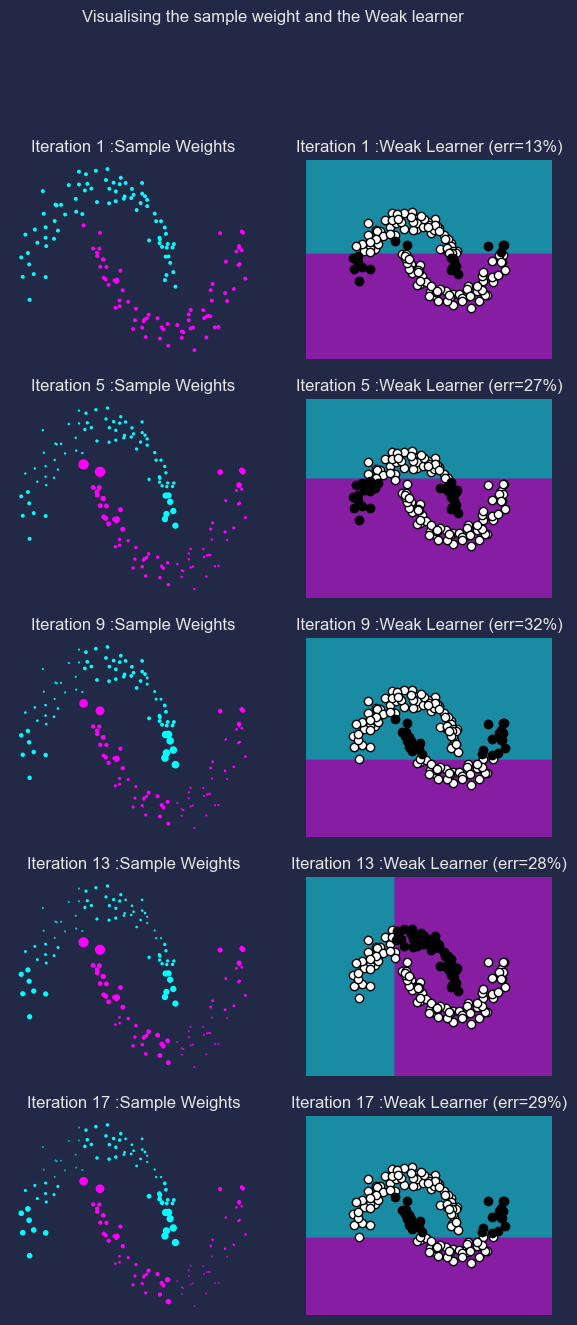

In [11]:
plt.figure(figsize=(7, 15))
plt.suptitle("Visualising the sample weight and the Weak learner")
estimators = fit_boosting(X_train, y_train, n_estimators=20, visualize=True)

In [12]:
def visual_performance(X, y, n_estimators=10, visual_iter=None):
    if visual_iter is None:
        visual_iter = np.linspace(0, n_estimators, 8, dtype=int)
    n_samples, n_feature = X.shape
    weights = np.ones((n_samples,))
    ensemble = list()

    for t in range(n_estimators + 1):
        # setting the weights of each observation
        weights = np.divide(weights, np.sum(weights))

        # create decision stump as the weak learner
        stumps = DecisionTreeClassifier(max_depth=1)

        # weak learner learn the pattern in the data with sample weight, which tells the learner where to focus
        stumps.fit(X, y, sample_weight=weights)

        # making prediction
        y_pred_ = stumps.predict(X)

        # error rate
        error_rate_ = 1 - accuracy_score(y, y_pred_, sample_weight=weights)

        # find the weight of the weak learner which proportional to accuracy
        alpha_ = 0.5 * np.log((1 - error_rate_) / error_rate_)

        # identify the correctly and mis classified points
        m = (y == y_pred_) * 1 + (y != y_pred_) * -1

        # update the weights
        weights *= np.exp(-alpha_ * m)

        ensemble.append((alpha_, stumps))

        # plot the ensemble
        if t in visual_iter:
            iter_ = np.argwhere(visual_iter == t).squeeze() + 1
            ax = plt.subplot(2, 4, iter_)
            ensemble_pred = predict_boosting(X, ensemble)
            err = 1 - accuracy_score(y, ensemble_pred)
            plt.setp(ax, xticks=(), yticks=(), title=f"Iteration {t} : err = {err:.0%}",
                     xlim=(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5),
                     ylim=(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5))

            feature_1, feature_2 = np.meshgrid(
                np.linspace(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5),
                np.linspace(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)
            )
            grid = np.c_[feature_1.ravel(), feature_2.ravel()]
            grid_pred = np.reshape(predict_boosting(grid, ensemble), feature_1.shape)
            disp = DecisionBoundaryDisplay(xx0=feature_1, xx1=feature_2, response=grid_pred)
            disp.plot(ax=ax, alpha=0.25)

            mask_ = (y == ensemble_pred)
            plt.scatter(X[mask_, 0], X[mask_, 1], c="white", edgecolors="k", label="Correctly Classified")
            plt.scatter(X[~mask_, 0], X[~mask_, 1], c="red", edgecolors="k", label="Misclassification")



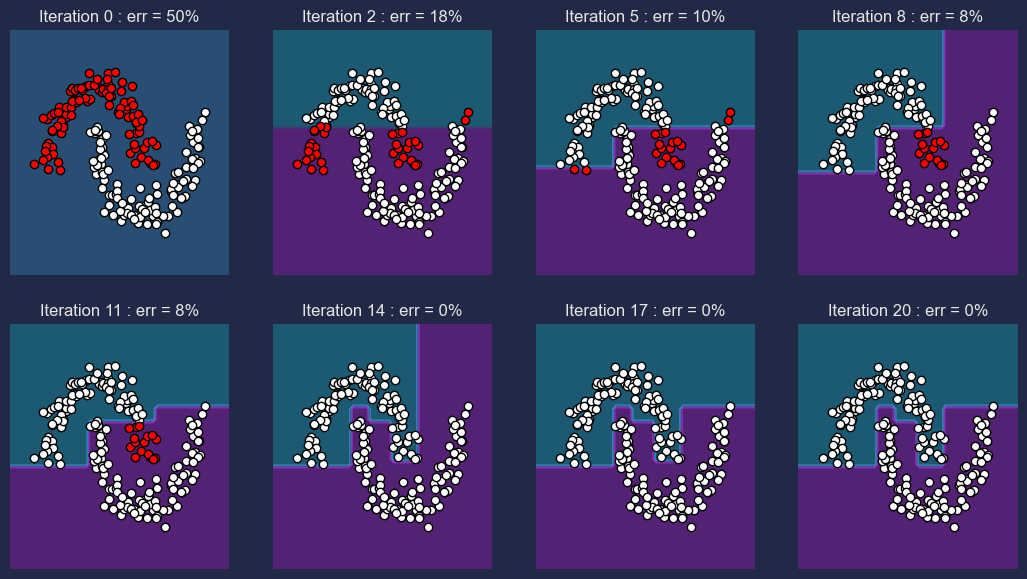

In [13]:
X, y = make_moons(n_samples=200, noise=0.125, random_state=555)
y = 2 * y - 1
plt.figure(figsize=(13, 7))
visual_performance(X, y, n_estimators=20)

## Using Sklearn

In [14]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier

X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=555)

In [15]:
shallow_tree = DecisionTreeClassifier(max_depth=2)
ensemble = AdaBoostClassifier(base_estimator=shallow_tree,
                              n_estimators=20, learning_rate=0.75, random_state=555)
ensemble.fit(X_train, y_train)

C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.75, n_estimators=20, random_state=555)

In [16]:
y_pred = ensemble.predict(X_test)
from sklearn.metrics import accuracy_score

err_rate = 1 - accuracy_score(y_test, y_pred)
err_rate

0.0699300699300699

### Multi Class classification

1. sklearn provide way to handle the multi class classification using `algorithm="SAMME"` parameter in the `AdaBooostCLassifier`.
2. `StageWise Additive Modeling using Multi class Exponentional loss` is full for SAMME.
3. In addition to SAMME , sklearn also provide `SAMME.R` option which can handle the class probability


In [17]:
from sklearn.datasets import load_iris

X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=555)

In [18]:
ensemble = AdaBoostClassifier(base_estimator=shallow_tree, n_estimators=20,
                              learning_rate=.75, algorithm="SAMME.R")
ensemble.fit(X_train, y_train)

C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.75, n_estimators=20)

In [19]:
y_pred = ensemble.predict(X_test)
err_rate = 1 - accuracy_score(y_test, y_pred)
err_rate

0.07894736842105265

## Impact of Outliers

AdaBoost is susceptible to outliers. Outlier is often misclassified by the weak learner.This make the Adaboost perform poorly on the dataset with outlier.

**Why this happening?**
1. if weak learner misclassified the observation ,we increase the weight of the misclassified observation.
2. by increasing hte weight of the observation , upcoming weak leaner in ensemble will give more focus on the misclassification done by the previous weak learner.
3. if upcoming weak learner also misclassified the weight will keep on increase.`Outliers force AdaBoost to spend a disproportionate amount of effort on training examples that are noisy`
4. if upcoming weak learner correctly classified the outlier then `ensemble will overfit`.

So , before using the ensemble always filter the outlier.

In [20]:
X, y = make_moons(n_samples=100, noise=0.05, random_state=555)

# adding the outlier
X = np.r_[X, [[-1.15, 0.8]]]
y = np.r_[y, [1]]

# convert the label into -1/+1
y = (2 * y) - 1

In [21]:
def visualize_impact_of_outlier(X, y, n_estimators=20, visual_iter=None):
    if visual_iter is None:
        visual_iter = np.linspace(0, n_estimators, 8, dtype=int)

    n_samples, n_features = X.shape
    # initialise the initial weight of each observation
    weights = np.ones((n_samples,))
    ensemble_ = list()

    for t in range(n_estimators + 1):
        weights = np.divide(weights, np.sum(weights))

        # visual the sample weights
        if t in visual_iter:
            s = weights / np.max(weights)
            s[(0.00 <= s) & (s < 0.25)] = 2
            s[(0.25 <= s) & (s < 0.50)] = 16
            s[(0.50 <= s) & (s < 0.75)] = 64
            s[(0.75 <= s) & (s <= 1.00)] = 128
            if t == 0:
                s = (s / np.max(s)) * 10
            plt_idx = np.argwhere(visual_iter == t).squeeze() + 1
            ax = plt.subplot(2, 4, plt_idx)
            plt.setp(ax, xticks=(), yticks=(), title=f"Iteration {t} : Sample Weights",
                     ylim=(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5),
                     xlim=(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5))
            plt.scatter(X[:, 0], X[:, 1], c=y, s=s)
            plt.scatter(X[-1:, 0], X[-1:, 1], c="r", s=s[-1])

        stumps = DecisionTreeClassifier(max_depth=1)

        # focus more on the weighted observation
        stumps.fit(X, y, sample_weight=weights)

        y_pred_ = stumps.predict(X)

        # error rate of each weak leaner
        error_rate_ = 1 - accuracy_score(y, y_pred_, sample_weight=weights)

        # alpha weights of each weak_learner based on error_rate
        alpha_ = 0.5 * np.log((1 - error_rate_) / error_rate_)

        # identify the misclassification
        m = (y == y_pred_) * 1 + (y != y_pred_) * -1
        weights *= np.exp(-m * alpha_)

        ensemble_.append((alpha_, stumps))


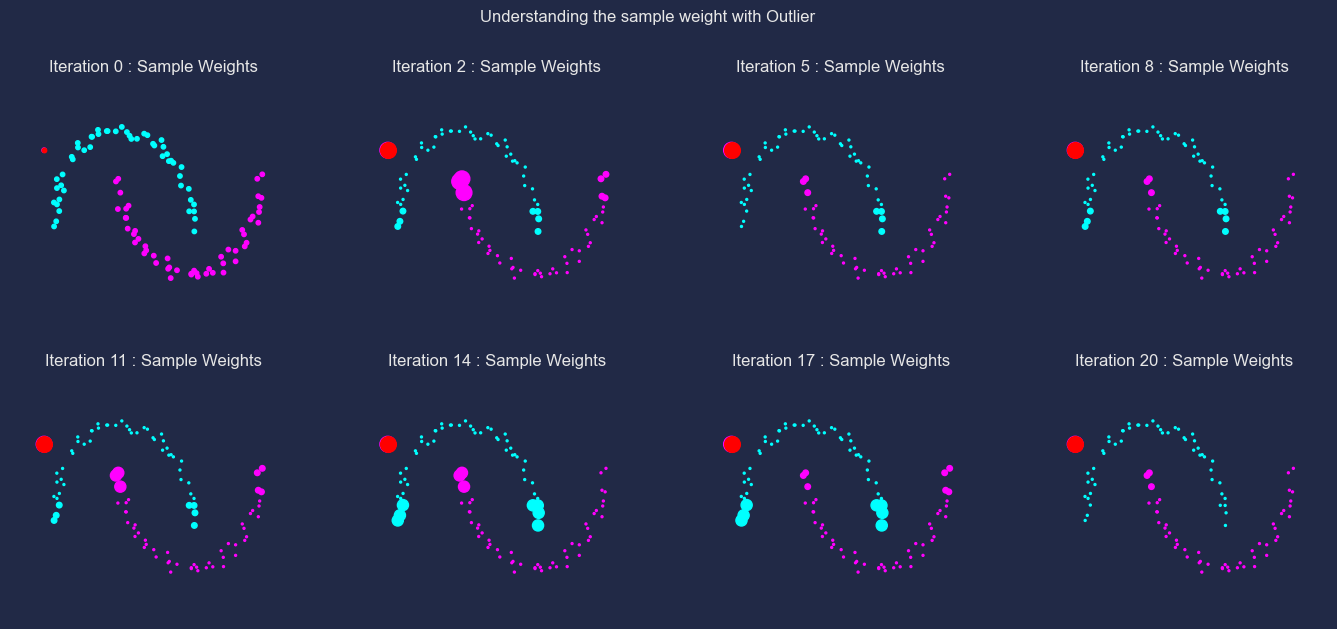

In [22]:
plt.figure(figsize=(17, 7))
plt.suptitle("Understanding the sample weight with Outlier")
visualize_impact_of_outlier(X, y, n_estimators=20)

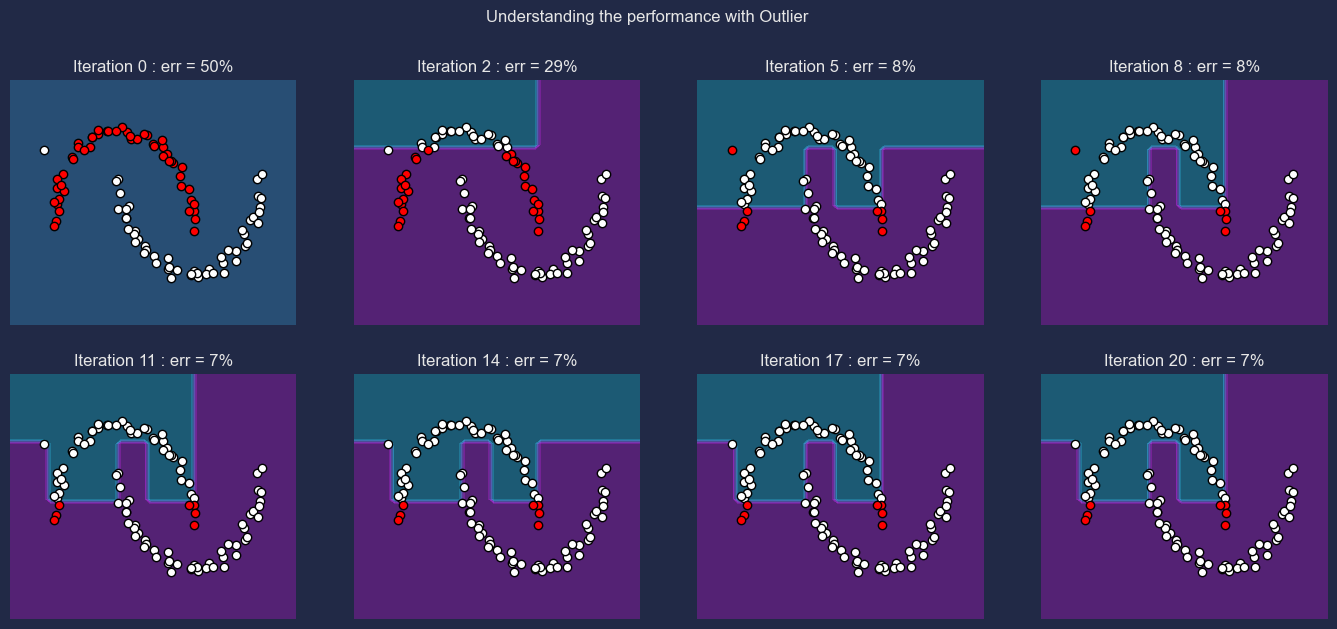

In [23]:
plt.figure(figsize=(17, 7))
plt.suptitle("Understanding the performance with Outlier")
visual_performance(X, y, n_estimators=20)

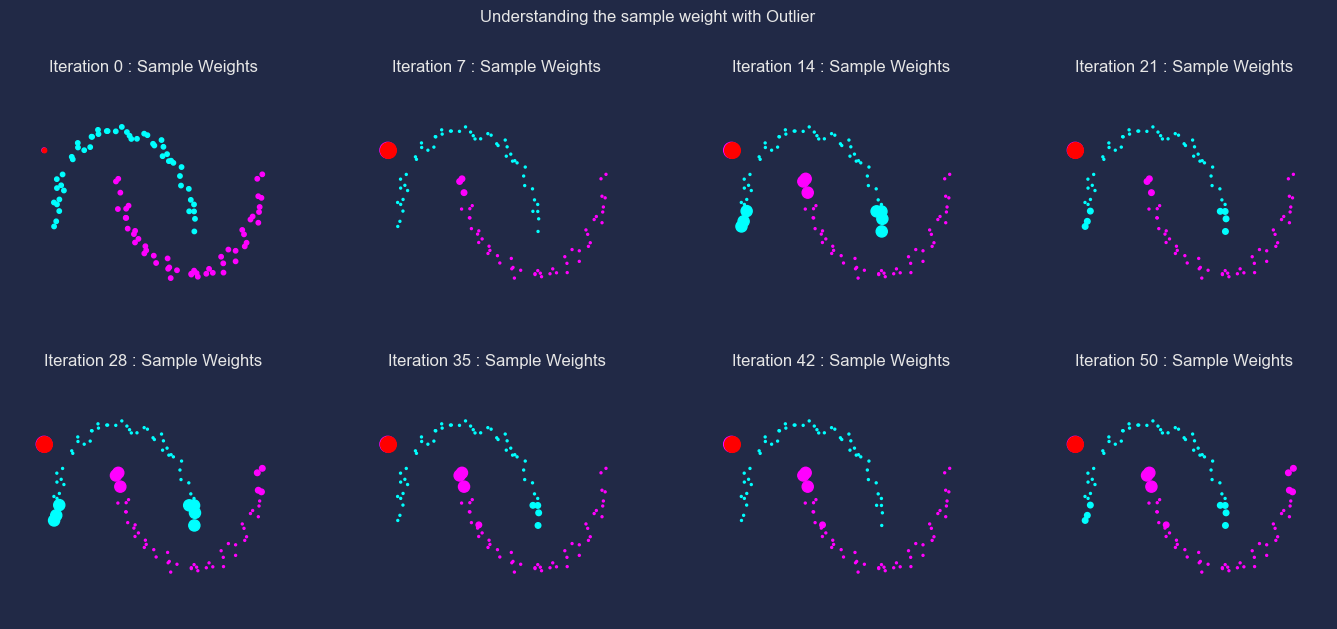

In [24]:
plt.figure(figsize=(17, 7))
plt.suptitle("Understanding the sample weight with Outlier")
visualize_impact_of_outlier(X, y, n_estimators=50)

red dot in the above graph is outlier point, size of point represent the weight ,as you can see the weight of outlier is increasing as the iteration increase even after the 50 iteration.

This means in every iteration upcoming weak learner tries hard to understand the about the outlier

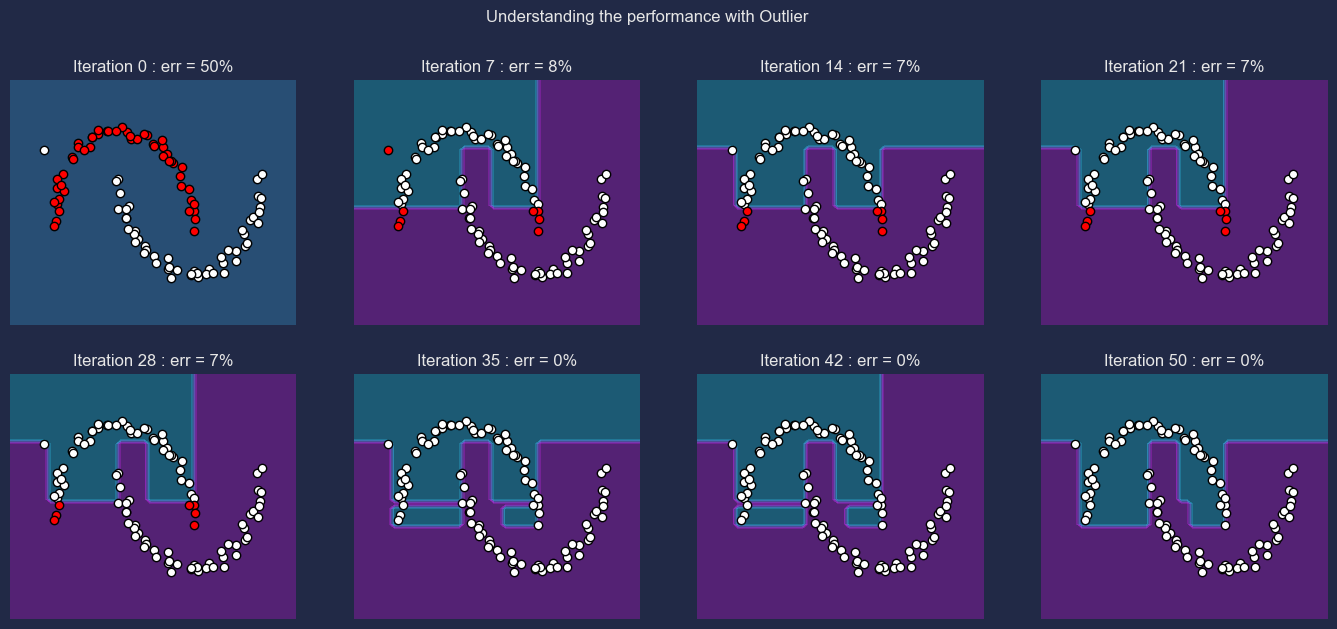

In [25]:
plt.figure(figsize=(17, 7))
plt.suptitle("Understanding the performance with Outlier")
visual_performance(X, y, n_estimators=50)

Adaboost overfit the data . due to the outlier points.

In [26]:
X, y = make_moons(n_samples=100, noise=0.05, random_state=555)

# convert the label into -1/+1
y = (2 * y) - 1

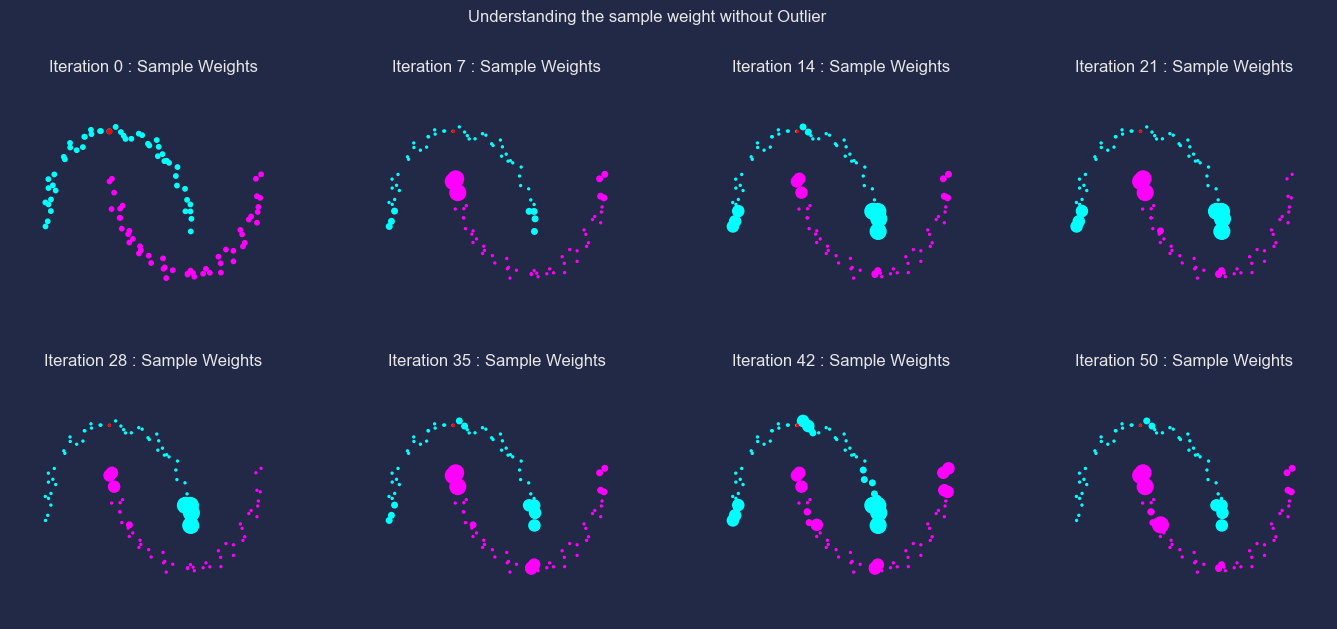

In [27]:
plt.figure(figsize=(17, 7))
plt.suptitle("Understanding the sample weight without Outlier")
visualize_impact_of_outlier(X, y, n_estimators=50)

there is no increasing trend in the sample weight , increase and decrease is happening

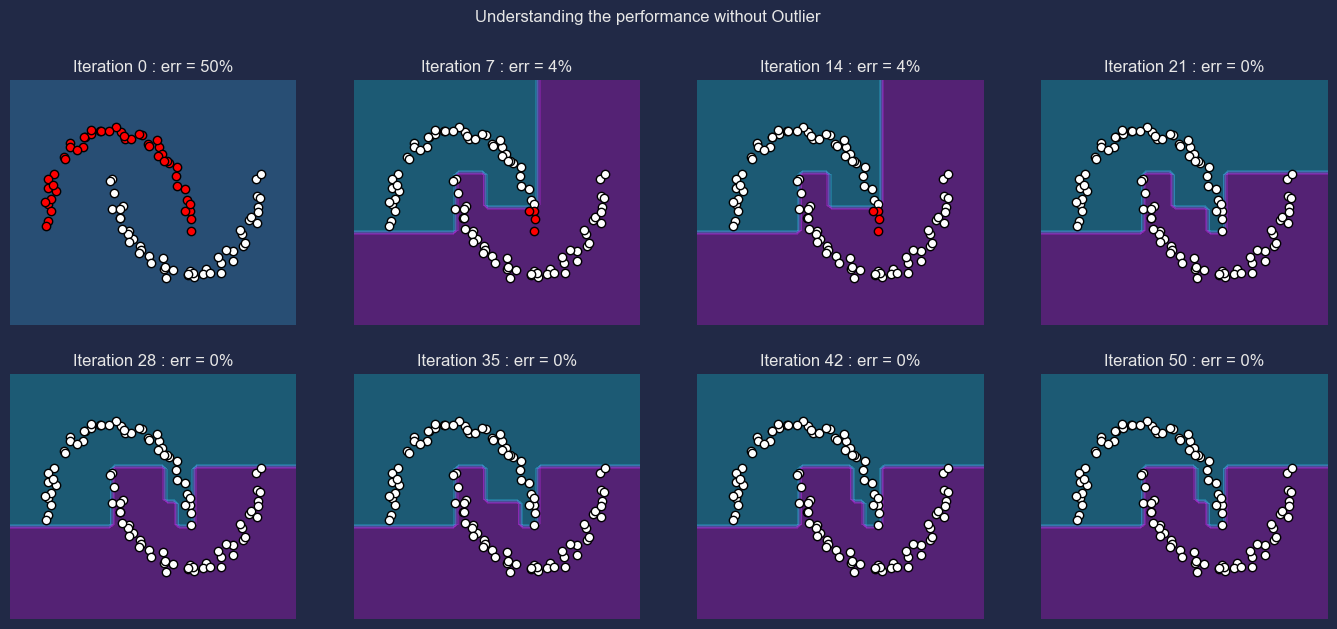

In [28]:
plt.figure(figsize=(17, 7))
plt.suptitle("Understanding the performance without Outlier")
visual_performance(X, y, n_estimators=50)

## Choosing the learning rate

Now, we look at ways in which we can train robust models with AdaBoost. The first aspect we can control is learning rate, which adjusts the contribution of each estimator to the ensemble.

For example, a learning rate of 0.75 tells AdaBoost to decrease the overall contribution of each base estimator by a factor of 0.75. When there are outliers, a high learning rate will cause their influence to grow proportionally quickly, which can absolutely kill the performance of your model. Therefore, one way to mitigate the effect of outliers is to lower the learning rate

In [29]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

X, y = load_breast_cancer(return_X_y=True)

In [30]:
n_learning_rate_step, n_folds = 10, 10
learning_rate = np.linspace(0.1, 1, num=n_learning_rate_step)

splitter = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=555)

train_error = np.zeros((n_learning_rate_step, n_folds))
val_error = np.zeros((n_learning_rate_step, n_folds))

In [31]:
stump = DecisionTreeClassifier(max_depth=1)
for i, lr in enumerate(learning_rate):
    for j, (train, val) in enumerate(splitter.split(X, y)):
        model = AdaBoostClassifier(n_estimators=10, learning_rate=lr, estimator=stump, algorithm="SAMME")
        model.fit(X[train, :], y[train])

        train_error[i, j] = (1 - accuracy_score(y[train], model.predict(X[train, :]))) * 100
        val_error[i, j] = (1 - accuracy_score(y[val], model.predict(X[val, :]))) * 100

mean_train_error = train_error.mean(axis=1)
mean_val_error = val_error.mean(axis=1)

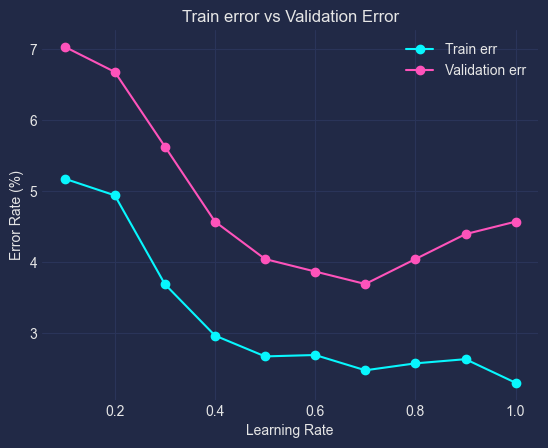

In [32]:
plt.plot(learning_rate, mean_train_error, label="Train err", marker="o")
plt.plot(learning_rate, mean_val_error, label="Validation err", marker="o")
plt.legend()
plt.title("Train error vs Validation Error")
plt.xlabel("Learning Rate")
plt.ylabel("Error Rate (%)")
plt.show()

Learning rate = 0.7 give the validation error and train error low in same time.

### Using the sklearn

In [33]:
def error_scorer(estimator, X, y):
    return (1 - accuracy_score(y, estimator.predict(X))) * 100

In [48]:
from sklearn.model_selection import validation_curve

train_error, val_error = validation_curve(
    estimator=AdaBoostClassifier(estimator=stump, n_estimators=10, algorithm="SAMME"),
    X=X, y=y, scoring=error_scorer, cv=splitter,
    param_name="learning_rate",
    param_range=learning_rate
)

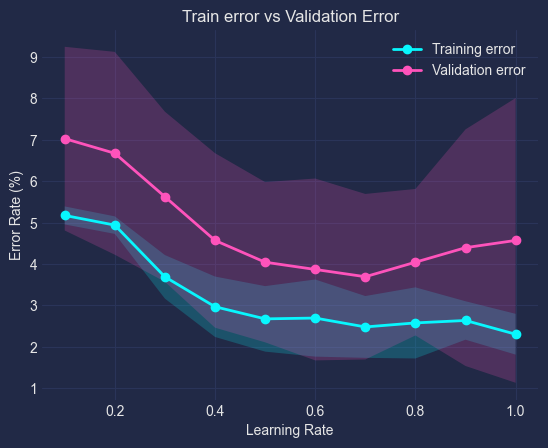

In [51]:
train_error_mean = np.mean(train_error, axis=1)
train_error_std = np.std(train_error, axis=1)
val_error_mean = np.mean(val_error, axis=1)
val_error_std = np.std(val_error, axis=1)

plt.plot(learning_rate, train_error_mean, label="Training error", lw=2, marker="o")
plt.plot(learning_rate, val_error_mean, label="Validation error", lw=2, marker="o")
plt.fill_between(
    learning_rate,
    train_error_mean - train_error_std,
    train_error_mean + train_error_std,
    alpha=0.2, lw=2
)
plt.fill_between(
    learning_rate,
    val_error_mean - val_error_std,
    val_error_mean + val_error_std,
    alpha=0.2, lw=2
)

plt.legend()
plt.title("Train error vs Validation Error")
plt.xlabel("Learning Rate")
plt.ylabel("Error Rate (%)")
plt.show()

## Early Stopping

Besides the learning_rate, the other important consideration for practical boosting is the number of base learners, n_estimators. It might be tempting to try to build an ensemble with a very large number of weak learners. However, this does not always translate to the best generalization performance.

In fact, it is often the case that we can achieve roughly the same performance with fewer base estimators than we think we might need. Identifying the least number of base estimators in order to build an effective ensemble is known as early stopping.

In [54]:
n_estimators_steps, n_folds = 5, 10
number_of_stumps = np.arange(5, 50, n_estimators_steps)

train_error = np.zeros((len(number_of_stumps), n_folds))
val_error = np.zeros((len(number_of_stumps), n_folds))

stump = DecisionTreeClassifier(max_depth=1)
for i, n_estimators in enumerate(number_of_stumps):
    for j, (train, val) in enumerate(splitter.split(X, y)):
        model = AdaBoostClassifier(algorithm="SAMME", estimator=stump,
                                   n_estimators=n_estimators, random_state=555)
        model.fit(X[train, :], y[train])

        train_error[i, j] = (1 - accuracy_score(y[train], model.predict(X[train, :]))) * 100
        val_error[i, j] = (1 - accuracy_score(y[val], model.predict(X[val, :]))) * 100

train_error_mean = np.mean(train_error, axis=1)
val_error_mean = np.mean(val_error, axis=1)

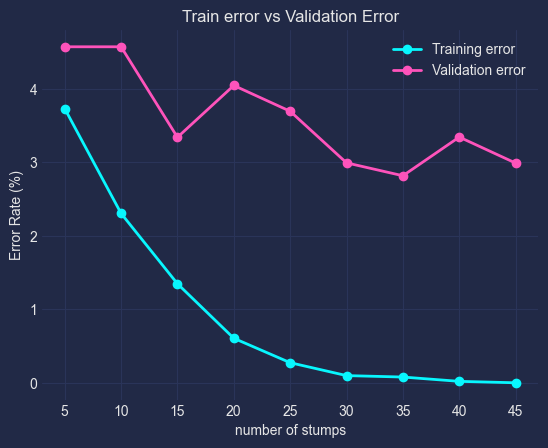

In [56]:
plt.plot(number_of_stumps, train_error_mean, label="Training error", lw=2, marker="o")
plt.plot(number_of_stumps, val_error_mean, label="Validation error", lw=2, marker="o")

plt.legend()
plt.title("Train error vs Validation Error")
plt.xlabel("number of stumps")
plt.ylabel("Error Rate (%)")
plt.show()

In [62]:
def visualize_validation_curve(estimator, X, y, params, scoring, n_splits=10, random_state=555):
    splitter_ = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
    for idx, (param_name, param_range) in enumerate(params.items(), start=1):
        train_error_, val_error_ = validation_curve(estimator=estimator, X=X, y=y,
                                                    param_name=param_name,
                                                    param_range=param_range,
                                                    cv=splitter_,
                                                    scoring=scoring)
        train_error_mean_ = np.mean(train_error_, axis=1)
        train_error_std_ = np.std(train_error_, axis=1)
        val_error_mean_ = np.mean(val_error_, axis=1)
        val_error_std_ = np.std(val_error_, axis=1)

        ax = plt.subplot(1, 2, idx)
        plt.setp(ax, xlabel=param_name, ylabel="Error Rate (%)", title=f"For {param_name}")
        plt.plot(param_range, train_error_mean_, marker='o', lw=2, label="Training Error")
        plt.plot(param_range, val_error_mean_, marker='o', lw=2, label="Validation Error")
        plt.fill_between(
            param_range,
            train_error_mean_ - train_error_std_,
            train_error_mean_ + train_error_std_,
            lw=2,
            alpha=0.5
        )
        plt.fill_between(
            param_range,
            val_error_mean_ - val_error_std_,
            val_error_mean_ + val_error_std_,
            lw=2,
            alpha=0.5
        )
        plt.legend()

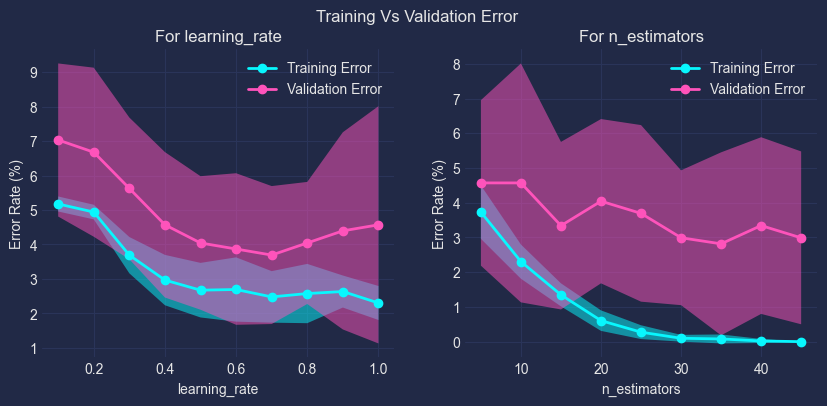

In [65]:
X, y = load_breast_cancer(return_X_y=True)
learning_rate = np.linspace(0.1, 1, num=10)
n_estimators = number_of_stumps = np.arange(5, 50, 5)
params = {"learning_rate": learning_rate,
          "n_estimators": n_estimators}
stump = DecisionTreeClassifier(max_depth=1)
estimator = AdaBoostClassifier(estimator=stump, algorithm="SAMME", n_estimators=10)

plt.figure(figsize=(10, 4))
plt.suptitle("Training Vs Validation Error")
visualize_validation_curve(estimator, X, y, params, scoring=error_scorer, n_splits=10, random_state=555)

## Analysis

### Upper Bound

If AdaBoost calls a weak learning algorithm several time and generates classifiers with weighted training errors ϵ1 . . .ϵT then the ensemble’s training error is bounded above
$$
\epsilon \leq 2^{T-1} \prod_{t=1}^T \sqrt{\epsilon_t\left(1-\epsilon_t\right)}
$$



In [119]:
def bound(t, e):
    return (2 ** (t-1)) * (np.sqrt((e * (1 - e))) ** t)
bound = np.vectorize(bound)

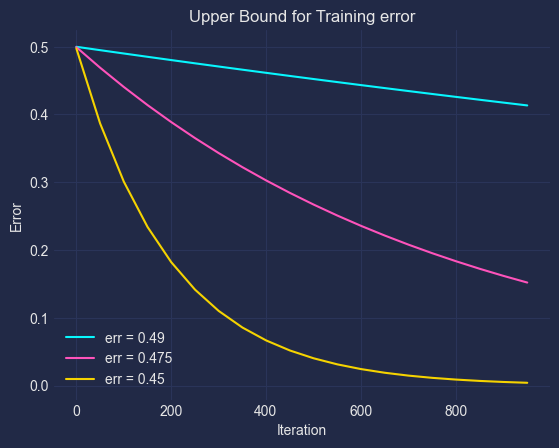

In [121]:
error_rates = [0.49, 0.475, 0.45]
iter_range = np.arange(1, 1000, 50)
for err in error_rates:
    plt.plot(iter_range,bound(iter_range,np.full(iter_range.shape,err)) ,
             label=f"err = {err}")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.title("Upper Bound for Training error")
plt.show()


if each base classifier is (at least slightly) better than random (i.e. ϵt < 0.5), then AdaBoost will converges
to zero training error as the number of iterations T goes to infinity